# Hate Speech Detection with BERT, Adversarial Training (FGM), and Explainability

This notebook implements a hate speech/offensive language detection model based on the project proposal. It fine-tunes a pre-trained BERT model using PyTorch, incorporating:

1.  **Data Loading & Preprocessing:** Handles TSV/CSV files, basic text cleaning, and preparation for BERT.
2.  **BERT Fine-tuning:** Uses Hugging Face Transformers for model loading and training.
3.  **Adversarial Training:** Implements the Fast Gradient Method (FGM) on embeddings as an optional technique to improve robustness.
4.  **Evaluation:** Calculates standard classification metrics (Accuracy, F1, Precision, Recall) and generates reports/visualizations.
5.  **Explainability:** Provides basic attention visualization to understand model focus.
6.  **Configuration:** Key parameters are set in a dedicated cell for easy experimentation.
7.  **Early Stopping:** Optional mechanism to prevent overfitting.
8.  **Artifact Saving:** Saves the trained model, tokenizer, results, and plots.

## 1. Setup and Imports

Import necessary libraries and set up basic configurations.

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import os
import json
import time
import random
from copy import deepcopy
from typing import Dict, List, Tuple, Optional
import re

# Check versions
print(f"PyTorch Version: {torch.__version__}")
print(f"Transformers Version: {transformers.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"NumPy Version: {np.__version__}")
# Check if sklearn exists before printing version (might not if running on minimal env)
try:
    import sklearn
    print(f"Scikit-learn Version: {sklearn.__version__}")
except ImportError:
    print("Scikit-learn not found.")

PyTorch Version: 2.7.0+cu118
Transformers Version: 4.51.3
Pandas Version: 2.2.3
NumPy Version: 2.1.3
Scikit-learn Version: 1.6.1


## 2. Configuration

Set hyperparameters, file paths, model name, and feature flags here. Adjust these values for your specific dataset and experiments.

In [ ]:
# --- Core Configuration ---
MODEL_NAME = 'bert-base-uncased'
MAX_LEN = 128  # Max sequence length for BERT tokenizer
BATCH_SIZE = 16 # Reduce if facing GPU memory issues
EPOCHS = 4     # Number of training epochs
LEARNING_RATE = 2e-5 # Standard learning rate for BERT fine-tuning
SEED = 42      # Random seed for reproducibility
OUTPUT_DIR = 'model_output' # Directory to save model, results, plots
VAL_SPLIT_SIZE = 0.1 # Proportion of training data to use for validation

# --- Dataset Configuration (MODIFY THESE) ---
BASE_DIR = os.getcwd()
# Choose one dataset type to configure
DATASET_TYPE = 'OLID' # Options: 'OLID', 'HASOC', 'OffenseEval'

# Example paths (Update with your actual file paths)
if DATASET_TYPE == 'OLID':
    DATA_DIR        = os.path.join(BASE_DIR, 'OlidPreprcessed')
    TRAIN_FILE      = os.path.join(DATA_DIR, 'OLID_Tain_ATUSER_URL_EmojiRemoved_Pedro.txt')
    TEST_FILE       = os.path.join(DATA_DIR, 'OLID_TEST_A_ATUSER_URL_EmojiRemoved_Pedro.txt')
    TEST_LABELS_FILE= None
    TEXT_COLUMN     = 'tweet'
    LABEL_COLUMN    = 'subtask_a'
    LABEL_MAP       = {'NOT': 0, 'OFF': 1}
    NUM_LABELS      = 2

elif DATASET_TYPE == 'HASOC':
    DATA_DIR        = os.path.join(BASE_DIR, 'HASOCData')
    TRAIN_FILE      = os.path.join(DATA_DIR, 'english_dataset.tsv')
    TEST_FILE       = os.path.join(DATA_DIR, 'hasoc2019_en_test-2919.tsv')
    TEST_LABELS_FILE= None
    TEXT_COLUMN     = 'text'
    LABEL_COLUMN    = 'task_1'
    LABEL_MAP       = {'NOT': 0, 'HOF': 1}
    NUM_LABELS      = 2

elif DATASET_TYPE == 'OffenseEval':
    DATA_DIR        = os.path.join(BASE_DIR, 'OffenseEval')
    TRAIN_DIR       = DATA_DIR
    # We'll glob the nine A-part files in code rather than list them manually here:
    part_paths = [
        os.path.join(TRAIN_DIR, f'task_a_part{i}.xlsx')
        for i in range(1, 9)
    ]
    # ...and similarly for task_b_distant.xlsx and task_c_distant_ann.xlsx in that same folder.
    # For now, we'll just use task_a_part1.xlsx for demonstration purposes.
    # You can modify the code to load all parts and concatenate them if needed.
    # For now, let's just load the first part:
    train_df = pd.read_excel(part_paths[0]) # Load the first part of the dataset
    # Concatenate all parts if needed (uncomment the following line):
    # train_df = pd.concat([pd.read_excel(path) for path in part_paths], ignore_index=True)
    print(f"Loaded {len(train_df)} training samples.")

    TEST_LABELS_FILE= None
    TEXT_COLUMN     = 'tweet'
    LABEL_COLUMN    = 'subtask_a'
    LABEL_MAP       = {'NOT': 0, 'OFF': 1}
    NUM_LABELS      = 2

else:
    raise ValueError("Invalid DATASET_TYPE. Choose from 'OLID', 'HASOC', 'OffenseEval'.")

# --- Feature Flags ---
USE_FGM = True # Set to True to enable Fast Gradient Method adversarial training
ADVERSARIAL_EPS = 0.01 # Epsilon for FGM perturbation (if USE_FGM is True)

USE_EARLY_STOPPING = False # Set to True to enable early stopping
PATIENCE = 3 # Number of epochs to wait for improvement before stopping (if USE_EARLY_STOPPING is True)

# --- Create output directory ---
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Save Configuration to JSON (for record keeping) ---
config_dict = {
    'MODEL_NAME': MODEL_NAME,
    'MAX_LEN': MAX_LEN,
    'BATCH_SIZE': BATCH_SIZE,
    'EPOCHS': EPOCHS,
    'LEARNING_RATE': LEARNING_RATE,
    'SEED': SEED,
    'OUTPUT_DIR': OUTPUT_DIR,
    'DATASET_TYPE': DATASET_TYPE,
    'BASE_DIR': BASE_DIR,
    'TRAIN_FILE': locals().get('TRAIN_FILE'),
    'TEST_FILE': locals().get('TEST_FILE'),
    'TEST_LABELS_FILE': TEST_LABELS_FILE,
    'TEXT_COLUMN': TEXT_COLUMN,
    'LABEL_COLUMN': LABEL_COLUMN,
    'LABEL_MAP': LABEL_MAP,
    'NUM_LABELS': NUM_LABELS,
    'VAL_SPLIT_SIZE': VAL_SPLIT_SIZE,
    'USE_FGM': USE_FGM,
    'ADVERSARIAL_EPS': ADVERSARIAL_EPS if USE_FGM else None,
    'USE_EARLY_STOPPING': USE_EARLY_STOPPING,
    'PATIENCE': PATIENCE if USE_EARLY_STOPPING else None
}

with open(os.path.join(OUTPUT_DIR, 'config.json'), 'w') as f:
    json.dump(config_dict, f, indent=4)

print("Configuration saved to config.json")

Configuration saved to config.json


## 3. Environment Setup

Set random seeds for reproducibility and select the compute device (GPU if available, otherwise CPU).

In [7]:
def set_seed(seed_value: int):
    """Sets the seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
        # These two lines are for deterministic behavior, can slightly slow down training
        # torch.backends.cudnn.deterministic = True
        # torch.backends.cudnn.benchmark = False

set_seed(SEED)

# Select device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'Using GPU: {torch.cuda.get_device_name(0)}')
else:
    device = torch.device("cpu")
    print('Using CPU')

# Rough Training Time Estimate (for RTX 2080 Ti):
# Depending on dataset size (e.g., ~10k-100k samples) and MAX_LEN,
# expect training time to be roughly:
# - Small dataset (~10k): Few minutes per epoch.
# - Medium dataset (~50k-100k): 15-60 minutes per epoch.
# - Large dataset (>100k): Potentially several hours per epoch.
# FGM adds a small overhead (extra forward/backward pass per step).

Using GPU: NVIDIA GeForce RTX 2080 Ti


## 4. Data Loading and Preprocessing

Load data from files, perform basic cleaning, map labels, and split into train/validation/test sets.

In [31]:
def preprocess_text(text: str) -> str:
    """Basic text cleaning for social media text."""
    if not isinstance(text, str):
        text = str(text)
    text = text.lower() # Lowercase
    # Replace user mentions (keeping a generic token might be useful)
    text = re.sub(r'@\w+', '@USER', text)
    # Optional: Replace URLs
    text = re.sub(r'http\S+|www.\S+', 'HTTPURL', text)
    # Optional: Remove punctuation (Generally NOT recommended for BERT initially)
    # import string
    # text = text.translate(str.maketrans('', '', string.punctuation))
    # Optional: Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Quick sanity‐check
assert preprocess_text("Hello  WORLD!!") == "hello world!!"
assert preprocess_text("@john check this out") == "@USER check this out"
print("Preprocessed text looks good.")


Preprocessed text looks good.


In [16]:
# Cell 3: Robust file loading + tests
def load_data(file_path: str, sep: str = '\t') -> Optional[pd.DataFrame]:
    """Load a TSV or CSV file, falling back if necessary."""
    print(f"Loading {file_path!r} (sep='{sep}')…")
    if not os.path.exists(file_path):
        print(f"❌ File not found: {file_path}")
        return None

    try:
        df = pd.read_csv(file_path, sep=sep, quoting=3, on_bad_lines='warn')
        print(f"✔️ Loaded with sep='{sep}', shape={df.shape}")
        return df
    except Exception as e:
        print(f"⚠️ Failed with sep='{sep}': {e}")

    if sep == '\t':
        print("→ Retrying with sep=','…")
        try:
            df = pd.read_csv(file_path, on_bad_lines='warn')
            print(f"✔️ Loaded with sep=',', shape={df.shape}")
            return df
        except Exception as e2:
            print(f"❌ Still failed: {e2}")

    return None

# You can test on a small temp CSV/TSV if you like
# e.g. df = load_data('tests/sample.tsv')

In [20]:
# Cell 4: Full pipeline: load, clean, split
def load_and_preprocess_data(
    train_path:    str,
    test_path:     str,
    text_col:      str,
    label_col:     str,
    label_map:     Dict[str, int],
    test_labels_path: Optional[str] = None,
    val_split:     float = 0.1,
    seed:          int = 42
) -> Tuple[pd.DataFrame, pd.DataFrame, Optional[pd.DataFrame]]:
    """Load train/test, apply preprocess_text, map labels, then split."""
    # --- Load ---
    df_train = load_data(train_path)
    if df_train is None:
        raise RuntimeError(f"Cannot load train data at {train_path}")
    df_test  = load_data(test_path)

    # --- Validate columns ---
    for df, name in [(df_train, 'train'), (df_test, 'test')]:
        if df is None: continue
        missing = {text_col, label_col} - set(df.columns)
        if missing:
            print(f"❌ {name} missing columns: {missing}")
            if name=='train':
                raise ValueError("Train data missing required columns.")
            else:
                df_test = None

    # --- Preprocess train ---
    df_train['clean_text'] = df_train[text_col].apply(preprocess_text)
    df_train['label']      = df_train[label_col].map(label_map)
    orig = len(df_train)
    df_train.dropna(subset=['clean_text','label'], inplace=True)
    df_train = df_train[df_train['clean_text'].str.len()>0]
    if len(df_train)<orig:
        print(f"⚠️ Dropped {orig-len(df_train)} invalid train rows")
    df_train['label'] = df_train['label'].astype(int)

    # --- Preprocess test (if present) ---
    if df_test is not None:
        df_test['clean_text'] = df_test[text_col].apply(preprocess_text)
        # map labels if in‐file, else try separate file, else dummy
        if label_col in df_test.columns:
            df_test['label'] = df_test[label_col].map(label_map)
        elif test_labels_path and os.path.exists(test_labels_path):
            labels_df = pd.read_csv(test_labels_path)
            lblcol   = labels_df.columns[1]
            labels_df = labels_df.rename(columns={lblcol:'label_str'})
            labels_df['label'] = labels_df['label_str'].map(label_map)
            if 'id' in df_test.columns and 'id' in labels_df.columns:
                df_test = df_test.merge(labels_df[['id','label']], on='id', how='left')
            else:
                df_test['label'] = 0
        else:
            print("⚠️ No test labels: setting to 0")
            df_test['label'] = 0

        orig_test = len(df_test)
        df_test.dropna(subset=['clean_text','label'], inplace=True)
        df_test = df_test[df_test['clean_text'].str.len()>0]
        if len(df_test)<orig_test:
            print(f"⚠️ Dropped {orig_test-len(df_test)} invalid test rows")
        df_test['label'] = df_test['label'].astype(int, errors='ignore')
        if not pd.api.types.is_numeric_dtype(df_test['label']):
            print("❌ Test labels non-numeric: discarding test set")
            df_test = None

    # --- Split train/val ---
    if df_train['label'].nunique()<2 or len(df_train)<2:
        print("❌ Not enough data/labels for split")
        return None, None, df_test[['clean_text','label']] if df_test is not None else None

    try:
        df_tr, df_val = train_test_split(
            df_train[['clean_text','label']],
            test_size=val_split,
            random_state=seed,
            stratify=df_train['label']
        )
    except ValueError:
        df_tr, df_val = train_test_split(
            df_train[['clean_text','label']],
            test_size=val_split,
            random_state=seed
        )

    return df_tr.reset_index(drop=True), df_val.reset_index(drop=True), (
           df_test[['clean_text','label']].reset_index(drop=True) if df_test is not None else None
    )


In [21]:
# Cell 5: Execute full pipeline
df_train, df_val, df_test = load_and_preprocess_data(
    train_path       = TRAIN_FILE,
    test_path        = TEST_FILE,
    text_col         = TEXT_COLUMN,
    label_col        = LABEL_COLUMN,
    label_map        = LABEL_MAP,
    test_labels_path = TEST_LABELS_FILE,
    val_split        = VAL_SPLIT_SIZE,
    seed             = SEED
)

print(f"▶️ Train: {len(df_train)} rows; Val: {len(df_val)} rows; Test: {len(df_test) if df_test is not None else 'N/A'}")
print("Train label dist:\n", df_train['label'].value_counts(normalize=True))
print("Val   label dist:\n", df_val['label'].value_counts(normalize=True))

Loading '/OlidPreprcessed/OLID_Tain_ATUSER_URL_EmojiRemoved_Pedro.txt' (sep='	')…
✔️ Loaded with sep='	', shape=(13240, 5)
Loading '/OlidPreprcessed/OLID_TEST_A_ATUSER_URL_EmojiRemoved_Pedro.txt' (sep='	')…
✔️ Loaded with sep='	', shape=(860, 2)
❌ test missing columns: {'subtask_a'}
▶️ Train: 11916 rows; Val: 1324 rows; Test: N/A
Train label dist:
 label
0    0.667674
1    0.332326
Name: proportion, dtype: float64
Val   label dist:
 label
0    0.667674
1    0.332326
Name: proportion, dtype: float64


## 5. PyTorch Dataset and DataLoader

Create a custom PyTorch `Dataset` to handle text tokenization on-the-fly and `DataLoader` for batching.

In [23]:
class TextClassificationDataset(Dataset):
    """PyTorch Dataset for text classification tasks."""
    def __init__(self, texts: List[str], labels: List[int], tokenizer: BertTokenizer, max_len: int):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self) -> int:
        return len(self.texts)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True, # Add '[CLS]' and '[SEP]'
            max_length=self.max_len,
            padding='max_length',    # Pad/truncate to max_len
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',     # Return PyTorch tensors
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# --- Initialize Tokenizer ---
print(f"Loading tokenizer for model: {MODEL_NAME}")
try:
    tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
except Exception as e:
    raise SystemExit(f"Failed to load tokenizer {MODEL_NAME}: {e}. Check model name and internet connection.")


# --- Create Datasets ---
train_dataset = TextClassificationDataset(
    texts=df_train['clean_text'].tolist(),
    labels=df_train['label'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

val_dataset = TextClassificationDataset(
    texts=df_val['clean_text'].tolist(),
    labels=df_val['label'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_dataset = None # Initialize as None
if df_test is not None and len(df_test) > 0:
    test_dataset = TextClassificationDataset(
        texts=df_test['clean_text'].tolist(),
        labels=df_test['label'].tolist(), # Uses the loaded/assigned test labels
        tokenizer=tokenizer,
        max_len=MAX_LEN
    )
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    print(f"Test DataLoader created with {len(test_dataset)} samples.")
else:
    test_loader = None
    print("Test data not available or empty. Test evaluation will be skipped.")


# --- Create DataLoaders ---
# Use persistent_workers=True for num_workers > 0 and PyTorch 1.7+
# This helps avoid shutting down workers between epochs.
persistent_workers = True if torch.__version__ >= '1.7' and torch.cuda.is_available() else False
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, persistent_workers=persistent_workers)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, persistent_workers=persistent_workers)

print(f"Train DataLoader created with {len(train_dataset)} samples.")
print(f"Validation DataLoader created with {len(val_dataset)} samples.")
print(f"DataLoaders created with batch size: {BATCH_SIZE}")

Loading tokenizer for model: bert-base-uncased
Test data not available or empty. Test evaluation will be skipped.
Train DataLoader created with 11916 samples.
Validation DataLoader created with 1324 samples.
DataLoaders created with batch size: 16


## 6. Model Loading

Load the pre-trained BERT model for sequence classification.

In [24]:
print(f"Loading pre-trained model: {MODEL_NAME}")
try:
    model = BertForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=NUM_LABELS, # Binary classification
        # output_attentions=True, # Set to True if you want attentions *during training*
        # output_hidden_states=True, # Set to True if you want hidden states *during training*
    )
except Exception as e:
    raise SystemExit(f"Failed to load model {MODEL_NAME}: {e}. Check model name and internet connection.")

# Move model to the appropriate device
model.to(device)
print("Model loaded and moved to device.")

Loading pre-trained model: bert-base-uncased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded and moved to device.


## 7. Adversarial Training (FGM)

Define the Fast Gradient Method (FGM) class to perturb word embeddings during training. This is applied only if `USE_FGM` is `True`.

In [25]:
class FGM:
    """
    Fast Gradient Method (FGM) for adversarial training on word embeddings.
    Applies perturbation to the model's embedding matrix.
    """
    def __init__(self, model: nn.Module, emb_name: str = 'word_embeddings', epsilon: float = 1.0):
        self.model = model
        self.epsilon = epsilon
        self.emb_name = emb_name # Usually 'word_embeddings' in BERT
        self.backup = {}
        self.embedding_layer_param = None

        # Find the parameter corresponding to the embedding layer dynamically
        for name, param in self.model.named_parameters():
            # Check if the parameter's name contains the embedding layer name
            if self.emb_name in name:
                print(f"FGM: Found embedding layer parameter: {name}")
                self.embedding_layer_param = param
                self.embedding_param_name = name
                break

        if self.embedding_layer_param is None:
            print(f"Warning: FGM could not find embedding layer parameter named like '{self.emb_name}'. Adversarial training will be disabled.")

    def attack(self):
        """Calculates and applies the perturbation."""
        # Only attack during training and if the embedding parameter was found
        if self.embedding_layer_param is None or not self.model.training:
            return

        # Get the parameter and its gradient
        param = self.embedding_layer_param
        if param.requires_grad and param.grad is not None:
             self.backup[self.embedding_param_name] = param.data.clone()
             # Calculate the perturbation r_at
             norm = torch.norm(param.grad)
             if norm != 0 and not torch.isnan(norm):
                r_at = self.epsilon * param.grad / norm
                param.data.add_(r_at) # Apply the perturbation
             # else:
                # print(f"Warning: Zero or NaN norm for gradient of {self.embedding_param_name}. Skipping perturbation.")
        # else:
             # print(f"Warning: Gradient for {self.embedding_param_name} is None or requires_grad=False. Skipping FGM attack for this step.")


    def restore(self):
        """Restores the original embedding weights."""
        if self.embedding_layer_param is None:
            return

        # Restore the parameter data from backup
        if self.embedding_param_name in self.backup:
            self.embedding_layer_param.data = self.backup[self.embedding_param_name]
        self.backup = {} # Clear the backup

# Initialize FGM if enabled
fgm = None
if USE_FGM:
    print("Initializing FGM...")
    # For Hugging Face BERT, the embeddings are typically model.bert.embeddings.word_embeddings.weight
    # We need to find the parameter corresponding to this weight tensor.
    # The FGM class now searches for the parameter name containing 'word_embeddings'.
    fgm = FGM(model, emb_name='word_embeddings', epsilon=ADVERSARIAL_EPS)
    if fgm.embedding_layer_param is None:
        print("Disabling FGM as embedding layer parameter was not found.")
        USE_FGM = False # Disable if initialization failed
else:
    print("FGM Adversarial Training is disabled.")

Initializing FGM...
FGM: Found embedding layer parameter: bert.embeddings.word_embeddings.weight


## 8. Training Loop

Define functions for a single training epoch and evaluation, then implement the main training loop.

In [26]:
def train_epoch(model: nn.Module, data_loader: DataLoader, loss_fn: nn.Module, optimizer: torch.optim.Optimizer, device: torch.device, scheduler: torch.optim.lr_scheduler._LRScheduler, n_examples: int, use_fgm: bool, fgm_instance: FGM | None):
    """Performs a single training epoch."""
    model.train() # Set model to training mode
    total_loss = 0
    correct_predictions = 0

    for batch_num, batch in enumerate(data_loader):
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # --- Standard Forward & Backward Pass ---
        optimizer.zero_grad() # Zero gradients at the start of the batch

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()

        # Calculate accuracy for the batch
        preds = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(preds == labels).item() # Use .item() for scalar

        # Standard backward pass to calculate gradients
        loss.backward()

        # --- FGM Attack (if enabled) ---
        if use_fgm and fgm_instance is not None:
            # Check if FGM was successfully initialized and can attack
            if fgm_instance.embedding_layer_param is not None and fgm_instance.embedding_layer_param.grad is not None:
                fgm_instance.attack() # Perturb embeddings based on current gradients

                # Adversarial forward pass
                outputs_adv = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                loss_adv = outputs_adv.loss

                # Adversarial backward pass (gradients accumulate)
                loss_adv.backward()

                fgm_instance.restore() # Restore original embeddings
            # else:
                 # print("FGM condition not met (embedding param not found or grad is None).")
        # --- End FGM ---

        # Clip gradients (optional but often helpful)
        # Applies to accumulated gradients if FGM was used
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update weights and learning rate
        optimizer.step()
        scheduler.step()

        # Print progress every N batches
        if (batch_num + 1) % 100 == 0:
             # Calculate batch accuracy using only current batch's data
             batch_preds = torch.argmax(outputs.logits, dim=1)
             batch_acc = torch.sum(batch_preds == labels).item() / len(labels)
             print(f'  Batch {batch_num + 1}/{len(data_loader)}, Loss: {loss.item():.4f}, Batch Acc: {batch_acc:.4f}')

    avg_loss = total_loss / len(data_loader)
    # Use correct_predictions accumulated across all batches for total accuracy
    accuracy = correct_predictions / n_examples
    return avg_loss, accuracy

def eval_model(model: nn.Module, data_loader: DataLoader, device: torch.device, n_examples: int, loss_fn: nn.Module = None):
    """Evaluates the model on a given dataset."""
    model.eval() # Set model to evaluation mode
    total_loss = 0
    correct_predictions = 0
    all_preds = []
    all_labels = []

    # Handle case where data_loader is None (e.g., test data not loaded)
    if data_loader is None or len(data_loader) == 0:
        print("Warning: Evaluation data loader is empty or None. Skipping evaluation.")
        # Return placeholder values or raise error depending on desired behavior
        return 0.0, 0.0, 0.0, 0.0, 0.0, [], []


    with torch.no_grad(): # Disable gradient calculations
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                # We pass labels here primarily to get the loss calculated by the model
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            # If loss_fn is provided, use it explicitly, otherwise use model output loss
            if loss_fn:
                 explicit_loss = loss_fn(logits, labels)
                 total_loss += explicit_loss.item()
            else:
                 total_loss += loss.item()


            preds = torch.argmax(logits, dim=1)
            correct_predictions += torch.sum(preds == labels).item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / n_examples

    # Calculate other metrics
    # Use 'weighted' to account for label imbalance
    # Set zero_division=0 to avoid warnings/errors if a class has no predictions/true labels
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

    return avg_loss, accuracy, f1, precision, recall, all_labels, all_preds

# --- Optimizer and Scheduler ---
# Parameters with requires_grad=False will be ignored automatically by AdamW
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)

# Calculate total training steps
num_training_steps = len(train_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0, # Optional: set a number of warmup steps (e.g., int(0.1 * num_training_steps))
    num_training_steps=num_training_steps
)

# Loss function (used explicitly in eval, model calculates it internally during training with labels)
loss_fn = nn.CrossEntropyLoss().to(device)

# --- Training Loop ---
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None
best_epoch = -1

print("Starting training...")
start_time = time.time()

for epoch in range(EPOCHS):
    epoch_start_time = time.time()
    print(f'\n--- Epoch {epoch + 1}/{EPOCHS} ---')

    train_loss, train_acc = train_epoch(
        model,
        train_loader,
        loss_fn, # Pass loss_fn even if not explicitly used in train_epoch (can be for logging)
        optimizer,
        device,
        scheduler,
        len(train_dataset), # Use dataset length for total samples
        USE_FGM, # Pass the flag
        fgm      # Pass the FGM instance
    )
    print(f'Epoch {epoch + 1} Training   -> Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')

    val_loss, val_acc, val_f1, val_precision, val_recall, _, _ = eval_model(
        model,
        val_loader,
        device,
        len(val_dataset), # Use dataset length for total samples
        loss_fn # Pass loss_fn
    )
    print(f'Epoch {epoch + 1} Validation -> Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, F1: {val_f1:.4f}')

    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)

    # --- Early Stopping Check ---
    if val_loss < best_val_loss:
        print(f'Validation loss improved ({best_val_loss:.4f} --> {val_loss:.4f}). Saving best model state...')
        best_val_loss = val_loss
        best_epoch = epoch
        # Save the best model state in memory
        best_model_state = deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f'Validation loss did not improve. Counter: {epochs_no_improve}/{PATIENCE}')

    # Activate early stopping if enabled and patience is reached
    if USE_EARLY_STOPPING and epochs_no_improve >= PATIENCE:
        print(f'\nEarly stopping triggered after {epoch + 1} epochs (no improvement for {PATIENCE} epochs).')
        break
    # --- End Early Stopping Check ---

    epoch_duration = time.time() - epoch_start_time
    print(f"Epoch duration: {epoch_duration:.2f} seconds")


total_training_time = time.time() - start_time
print(f'\nTotal Training Time: {total_training_time:.2f} seconds ({total_training_time/60:.2f} minutes)')

# --- Load the best model state found during training ---
if best_model_state is not None:
    print(f"\nLoading best model state from epoch {best_epoch + 1} for final evaluation and saving...")
    model.load_state_dict(best_model_state)
else:
    print("\nWarning: No best model state saved (e.g., training stopped too early, or no improvement). Using the final model state.")


Starting training...

--- Epoch 1/4 ---
  Batch 100/745, Loss: 0.6001, Batch Acc: 0.6875
  Batch 200/745, Loss: 0.4344, Batch Acc: 0.8125
  Batch 300/745, Loss: 0.6595, Batch Acc: 0.7500
  Batch 400/745, Loss: 0.5001, Batch Acc: 0.8750
  Batch 500/745, Loss: 0.6058, Batch Acc: 0.7500
  Batch 600/745, Loss: 0.3064, Batch Acc: 0.9375
  Batch 700/745, Loss: 0.9123, Batch Acc: 0.6250
Epoch 1 Training   -> Loss: 0.4683, Accuracy: 0.7819
Epoch 1 Validation -> Loss: 0.4350, Accuracy: 0.7938, F1: 0.7948
Validation loss improved (inf --> 0.4350). Saving best model state...
Epoch duration: 189.72 seconds

--- Epoch 2/4 ---
  Batch 100/745, Loss: 0.2393, Batch Acc: 0.8125
  Batch 200/745, Loss: 0.4502, Batch Acc: 0.8750
  Batch 300/745, Loss: 0.5772, Batch Acc: 0.8125
  Batch 400/745, Loss: 0.4601, Batch Acc: 0.8125
  Batch 500/745, Loss: 0.0905, Batch Acc: 1.0000
  Batch 600/745, Loss: 0.1977, Batch Acc: 0.9375
  Batch 700/745, Loss: 0.2131, Batch Acc: 0.9375
Epoch 2 Training   -> Loss: 0.3400, 

## 9. Final Evaluation

Evaluate the best performing model (based on validation loss) on the test set.

In [28]:
# Ensure test_loader exists before evaluating
if test_loader is not None:
    print("\nEvaluating on Test Set...")
    test_loss, test_acc, test_f1, test_precision, test_recall, test_labels, test_preds = eval_model(
        model,
        test_loader,
        device,
        len(test_dataset), # Use dataset length
        loss_fn
    )

    print(f'\nTest Set Results:')
    print(f'  Loss:      {test_loss:.4f}')
    print(f'  Accuracy:  {test_acc:.4f}')
    print(f'  F1-score:  {test_f1:.4f}')
    print(f'  Precision: {test_precision:.4f}')
    print(f'  Recall:    {test_recall:.4f}')

    # --- Classification Report ---
    print('\nClassification Report (Test Set):')
    # Get label names from the map for the report, sorted by their integer value
    try:
        target_names = [k for k, v in sorted(LABEL_MAP.items(), key=lambda item: item[1])]
        report = classification_report(test_labels, test_preds, target_names=target_names, digits=4, zero_division=0)
        print(report)
    except Exception as e:
        print(f"Could not generate classification report: {e}")
        report = "Could not generate classification report due to error."


    # --- Confusion Matrix ---
    print('\nConfusion Matrix (Test Set):')
    cm = confusion_matrix(test_labels, test_preds)
    print(cm)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    try:
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix (Test Set)')
        cm_path = os.path.join(OUTPUT_DIR, 'confusion_matrix.png')
        plt.savefig(cm_path)
        print(f"Confusion matrix plot saved to {cm_path}")
        # plt.show() # Uncomment to display inline
    except Exception as e:
        print(f"Could not plot confusion matrix: {e}")
        # Create a dummy plot to save if needed
        plt.text(0.5, 0.5, f'Error plotting CM: {e}', horizontalalignment='center', verticalalignment='center')
        plt.title('Confusion Matrix Plot Error')
        plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix_error.png'))
        plt.close()

else:
    print("\nSkipping test set evaluation as test data was not loaded or is empty.")
    # Assign default values for saving results later
    test_loss, test_acc, test_f1, test_precision, test_recall = 0.0, 0.0, 0.0, 0.0, 0.0
    test_labels, test_preds = [], []
    report = "Test data not available."
    cm = [[]]




Skipping test set evaluation as test data was not loaded or is empty.


## 10. Save Artifacts and Results

Save the trained model, tokenizer, training history plots, and final results.


Saving artifacts...
Best model and tokenizer saved to: model_output/best_model
Training history plot saved to model_output/training_history.png


AttributeError: 'list' object has no attribute 'tolist'

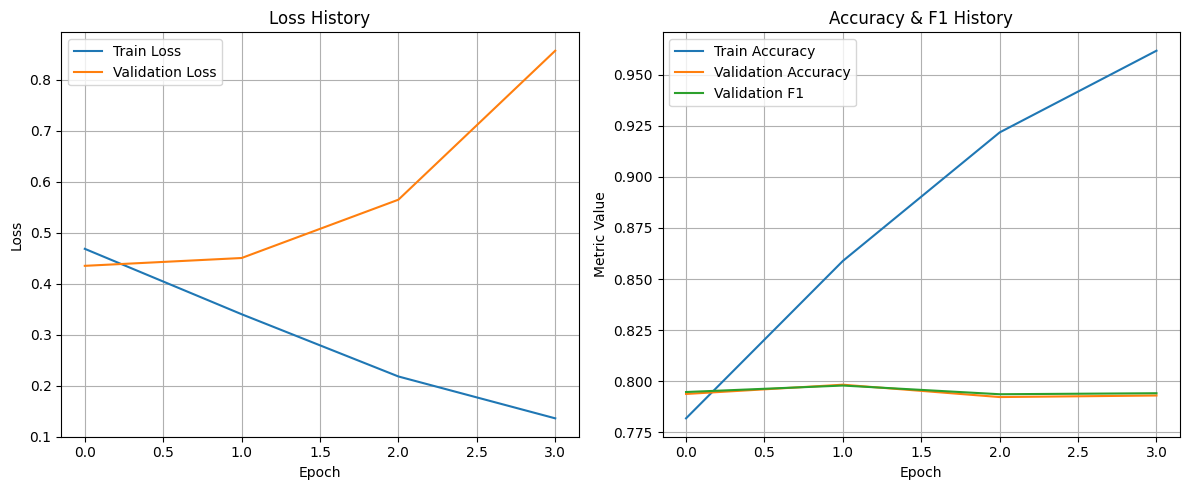

In [29]:
print("\nSaving artifacts...")

# --- Save Model and Tokenizer ---
# Save the best model state that was loaded after training
model_save_path = os.path.join(OUTPUT_DIR, 'best_model')
try:
    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(model_save_path)
    print(f"Best model and tokenizer saved to: {model_save_path}")
except Exception as e:
    print(f"Error saving model or tokenizer: {e}")

# --- Plot Training History ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.plot(history['val_f1'], label='Validation F1')
plt.title('Accuracy & F1 History')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
history_plot_path = os.path.join(OUTPUT_DIR, 'training_history.png')
try:
    plt.savefig(history_plot_path)
    print(f"Training history plot saved to {history_plot_path}")
    # plt.show() # Uncomment to display inline
except Exception as e:
    print(f"Error saving history plot: {e}")


# --- Save Configuration and Results to JSON ---
# Reuse config_dict from earlier
results = {
    'config': config_dict,
    'training_info': {
        'epochs_run': len(history['train_loss']), # Actual epochs run
        'total_training_time_seconds': total_training_time,
        'best_validation_loss': best_val_loss if best_model_state is not None else None, # Only if best model was tracked
        'best_epoch': best_epoch if best_model_state is not None else None
    },
    'history': history,
    'test_metrics': {
        'loss': test_loss,
        'accuracy': test_acc,
        'f1_score_weighted': test_f1,
        'precision_weighted': test_precision,
        'recall_weighted': test_recall
    },
    'classification_report': report,
    'confusion_matrix': cm.tolist() # Save matrix as list of lists
}

results_path = os.path.join(OUTPUT_DIR, 'results.json')
try:
    with open(results_path, 'w') as f:
        json.dump(results, f, indent=4)
    print(f"Configuration, history and results saved to {results_path}")
except Exception as e:
     print(f"Error saving results JSON: {e}")

print("\nArtifact saving complete.")

## 11. Explainability (Attention Visualization)

Load the trained model with `output_attentions=True` and visualize attention weights for a few examples from the test set. This provides a basic insight into which words the model focused on.

In [30]:
def visualize_attention(model: BertForSequenceClassification, tokenizer: BertTokenizer, text: str, device: torch.device, max_len: int, fig_title: str = "Average Attention from [CLS] Token (Last Layer)"):
    """Generates a basic attention visualization for a given text."""

    # Preprocess and tokenize the text
    processed_text = preprocess_text(text)
    inputs = tokenizer.encode_plus(
        processed_text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    ).to(device) # Move inputs to device

    # Ensure model outputs attentions (should have been loaded this way)
    if not model.config.output_attentions:
        print("Error: Model was not loaded with output_attentions=True. Cannot visualize attention.")
        print("Please reload the model with `output_attentions=True` before calling this function.")
        return None, None

    # Get model output (including attentions)
    model.eval()
    with torch.no_grad():
        # Passing labels here is optional for visualization, but doesn't hurt
        outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])

    # Extract attentions (tuple of tensors, one for each layer)
    # Shape: (num_layers, batch_size, num_heads, seq_len, seq_len)
    attentions = outputs.attentions

    # --- Process Attentions (Example: Average last layer's attention from [CLS]) ---
    # Get attentions from the last layer
    last_layer_attentions = attentions[-1].squeeze(0) # Shape: (num_heads, seq_len, seq_len)

    # Average attention scores across all heads
    avg_attention = torch.mean(last_layer_attentions, dim=0) # Shape: (seq_len, seq_len)

    # Focus on attention from the [CLS] token (index 0) to all other tokens
    # Squeeze(0) removes the batch dimension (batch_size=1)
    cls_attention = avg_attention[0, :].cpu().numpy() # Shape: (seq_len,)

    # Get tokens from the input_ids
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'].squeeze(0).cpu().numpy())

    # Filter out padding tokens (ids beyond the attention mask)
    # Find the last non-padded token index based on attention mask
    valid_len = inputs['attention_mask'].squeeze(0).sum().item()
    valid_tokens = tokens[:valid_len]
    valid_cls_attention = cls_attention[:valid_len]

    # Normalize attention scores for better visualization (optional, but often helps)
    # Normalize so scores sum to 1 across the sequence
    attention_sum = np.sum(valid_cls_attention[1:]) # Sum attention excluding CLS itself
    if attention_sum > 0:
         valid_cls_attention[1:] = valid_cls_attention[1:] / attention_sum

    # --- Plotting ---
    # Adjust figure size based on number of tokens
    fig_width = max(8, len(valid_tokens) * 0.5) # Minimum width 8, then proportional to tokens
    fig, ax = plt.subplots(figsize=(fig_width, 2))
    im = ax.imshow([valid_cls_attention], cmap='viridis', aspect='auto')

    ax.set_xticks(np.arange(len(valid_tokens)))
    ax.set_yticks([0])
    ax.set_xticklabels(valid_tokens, rotation=90, fontsize=10)
    ax.set_yticklabels(['[CLS] Attention'])

    # Add colorbar
    cbar = fig.colorbar(im, orientation='horizontal', fraction=0.05, pad=0.2)
    # Optional: Add value labels on heatmap (can be noisy for many tokens)
    # for i in range(len(valid_tokens)):
    #     ax.text(i, 0, f'{valid_cls_attention[i]:.2f}', ha='center', va='center', color='white' if valid_cls_attention[i] > np.mean(valid_cls_attention) else 'black', fontsize=8)

    plt.title(f'{fig_title}\nText: "{text[:80]}..."') # Truncate text for title
    plt.tight_layout()

    return fig, processed_text # Return figure and processed text

# --- Reload model with output_attentions=True ---
# Check if test_loader is available, otherwise cannot visualize on test data
if test_loader is not None:
    print("\nReloading model for attention visualization...")
    # Model was saved to OUTPUT_DIR/best_model
    model_path = os.path.join(OUTPUT_DIR, 'best_model')

    try:
        # Critical: Load with output_attentions=True
        # We load from_pretrained from the saved directory, not from the internet
        model_for_viz = BertForSequenceClassification.from_pretrained(model_path, output_attentions=True)
        model_for_viz.to(device)
        model_for_viz.eval() # Ensure evaluation mode
        print("Model reloaded successfully for visualization.")

        # Get label names from the map for printing
        target_names = [k for k, v in sorted(LABEL_MAP.items(), key=lambda item: item[1])]

        # --- Visualize Attention for Sample Texts ---
        # Take a few samples from the test set dataframe (df_test)
        num_samples_to_viz = 5
        # Ensure df_test is not None and has enough rows
        if df_test is not None and len(df_test) > 0:
            sample_indices = df_test.sample(n=min(num_samples_to_viz, len(df_test)), random_state=SEED).index

            for i, idx in enumerate(sample_indices):
                # Use the already cleaned text from the dataframe
                original_text = df_test.loc[idx, 'clean_text']

                # Try to get the true label if available, otherwise use dummy 0
                true_label_int = df_test.loc[idx, 'label'] if 'label' in df_test.columns else 0
                try:
                    true_label_str = target_names[true_label_int]
                except (IndexError, TypeError):
                     true_label_str = f"Unknown ({true_label_int})"


                print(f"\n--- Visualizing Sample {i+1} (Index in test df: {idx}) ---")
                print(f"Text: {original_text}")
                print(f"True Label: {true_label_str} ({true_label_int})")

                # Predict with the visualization model to get the predicted label
                inputs = tokenizer.encode_plus(original_text, return_tensors='pt', max_length=MAX_LEN, padding='max_length', truncation=True).to(device)
                with torch.no_grad():
                    outputs = model_for_viz(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
                pred_label_int = torch.argmax(outputs.logits, dim=1).item()
                try:
                     pred_label_str = target_names[pred_label_int]
                except (IndexError, TypeError):
                     pred_label_str = f"Unknown ({pred_label_int})"
                print(f"Predicted Label: {pred_label_str} ({pred_label_int})")

                # Generate visualization
                fig, _ = visualize_attention(model_for_viz, tokenizer, original_text, device, MAX_LEN)
                if fig:
                    viz_path = os.path.join(OUTPUT_DIR, f'attention_viz_sample_{idx}.png')
                    try:
                         fig.savefig(viz_path, bbox_inches='tight')
                         print(f"Attention visualization saved to: {viz_path}")
                         plt.show() # Display inline
                    except Exception as e:
                         print(f"Error saving attention plot for sample {idx}: {e}")
                         plt.close(fig) # Close the figure if saving failed
                else:
                     print("Skipping visualization due to error in function.")
        else:
            print("Cannot visualize attention: Test dataframe is empty or None.")

    except Exception as e:
        print(f"\nError during attention visualization setup or execution: {e}")
        print("Skipping attention visualization.")

else:
     print("\nSkipping attention visualization as test data is not available.")




Skipping attention visualization as test data is not available.


## 12. Conclusion and Next Steps

This notebook demonstrated the process of fine-tuning BERT for hate speech detection, optionally using FGM for adversarial robustness, evaluating performance, and gaining basic insights via attention visualization.

**Potential Next Steps:**

*   **Hyperparameter Tuning:** Systematically tune `LEARNING_RATE`, `BATCH_SIZE`, `MAX_LEN`, `ADVERSARIAL_EPS`, `PATIENCE` using tools like Optuna or Weights & Biases Sweeps.
*   **Dataset Adaptability:** Refine the `load_and_preprocess_data` function to more robustly handle different dataset formats (especially OffenseEval parts) or create dataset-specific loading functions.
*   **Advanced Adversarial Training:** Implement PGD (Projected Gradient Descent) or explore libraries like TextAttack for more sophisticated attacks and defenses.
*   **Enhanced Explainability:** Integrate libraries like Captum to use methods like Integrated Gradients, SHAP, or LIME for more detailed feature importance analysis.
*   **Error Analysis:** Analyze misclassified examples from the test set to understand model weaknesses and potential biases.
*   **Model Exploration:** Experiment with other transformer architectures like RoBERTa, DeBERTa, etc.
*   **Data Augmentation:** Incorporate techniques like back-translation or synonym replacement (e.g., using `nlpaug`) during training.
*   **Weights & Biases Integration:** Uncomment and configure the (currently missing) wandb integration code for comprehensive experiment tracking.
*   **Deployment:** Explore ways to deploy the trained model for real-time inference using libraries like FastAPI or Flask.